# Лабораторная работа №223

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Подготовка данных

Из общего файла раскидываем данные по отдельным файлам.

**Читаем данные из общего файла**

In [6]:
data = pd.read_csv('223.csv', sep=';')

**Вспомогательные функции для записи данных в различные файлы**

In [7]:
def make_mask(data, color, shade):
    
    mask = (data['color'] == color) & (data['shade'] == shade)
    
    return mask

In [8]:
def get_color_shade_data(data, color, shade, diff):
    
    mask = make_mask(data, color, shade)

    color_shade_data = data.loc[mask].copy()
    sqr_distance = (color_shade_data.pop('distance') - diff) ** 2
    color_shade_data['distance sqr'] = sqr_distance
    
    return color_shade_data

In [9]:
def write_to_file(x, y, filename):
    file = open(filename, 'w')
    
    for i in range(len(x)):
        string = str(x[i]) + ' ' + str(y[i])
        file.write(string + '\n')
        
    file.close()

In [10]:
def write_colored_data_to_file(data, color, shade, filename, diff=0):
    
    color_shade_data = get_color_shade_data(data, color, shade, diff)
    
    numbers = color_shade_data['number'].to_numpy()
    distances = color_shade_data['distance sqr'].to_numpy()
    
    write_to_file(numbers, distances, filename)

**Записываем данные в разные файлы**

In [11]:
write_colored_data_to_file(data, 'blue', 'dark', '223_bd.txt')
write_colored_data_to_file(data, 'blue', 'light', '223_bl.txt')
write_colored_data_to_file(data, 'red', 'dark', '223_rd.txt')
write_colored_data_to_file(data, 'red', 'light', '223_rl.txt')
write_colored_data_to_file(data, 'yellow', 'dark', '223_yd.txt', 11.755)
write_colored_data_to_file(data, 'yellow', 'light', '223_yl.txt', 11.755)
write_colored_data_to_file(data, 'green', 'dark', '223_gd.txt', 11.755)
write_colored_data_to_file(data, 'green', 'light', '223_gl.txt', 11.755)

## Обработка данных

Строим график линейных функций МНК по данным из отдельных файлов

**Класс для построения МНК**

In [32]:
class MNK():
    """
    Special class to store all data for linear MNK
    and make all necessary calculations
    
    """
    def __init__(self, input_filename):
        self.__input_filename = input_filename
        self.__x = []
        self.__y = []
        self.__k = 0.
        self.__b = 0.
        self.__sigma_k = 0.0
        self.__sigma_b = 0.0
        
    def __count_k(self):
        """
        Calculates slope ratio k and sigma_k
        
        """
        try:
            up = np.mean(self.__x * self.__y) - np.mean(self.__x) * np.mean(self.__y)
            down = np.mean(self.__x ** 2) - np.mean(self.__x) ** 2
            
            if down == 0:
                raise ZeroDivisionError
                
            self.__k = up / down
            cov_y = np.mean(self.__y ** 2) - np.mean(self.__y) ** 2
            under_sqrt = cov_y / down - self.__k ** 2
            
            if under_sqrt < 0:
                raise RuntimeError
                
            self.__sigma_k = np.sqrt(under_sqrt / len(self.__x))
            
        except ZeroDivisionError:
            print('Error: ZeroDivision in __count_k()')
            
        except RuntimeError:
            print('Error: NegativeValue under square root in __count_k()')
            
    def __count_b(self):
        """
        Calculates vertical shift 
        
        """
        try:
            self.__b = np.mean(self.__y) - self.__k * np.mean(self.__x)
            under_sqrt = np.mean(self.__x ** 2) - np.mean(self.__x) ** 2
            
            if under_sqrt < 0:
                raise RuntimeError
                
            self.__sigma_b = np.sqrt(np.mean(self.__x ** 2)) * self.__sigma_k
            
        except RuntimeError:
            print('Error: NegativeValue undeer square root in __count_b()')
            
    def read_data(self):
        """
        Read x and y values
        
        """
        try:
            file = open(self.__input_filename, 'r')
            lines = [line.strip() for line in file]
            
            for i, line in enumerate(lines):
                lines[i] = line.split()
                
            data = list(zip(*lines))
            self.__x = np.array(data[0], dtype=np.float64)
            self.__y = np.array(data[1], dtype=np.float64)
            
            file.close()
            
        except FileNotFoundError:
            print(f"File '{self.__input_filename}' doesn't exist")
            
    def show_schedule(self):
        """
        Build schedules:
        
        y = k * x + b 
        y = (k + sigma) * x + b
        y = (k - sigma) * x + b
        y = k * x + b + sigma
        y = k * x + b - sigma
        
        """
        
        self.__count_k()
        self.__count_b()
        
        fig = plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
        ax = fig.add_axes([0, 0, 1, 1])
        
        for i in range(len(self.__x)):
            ax.scatter(self.__x[i], self.__y[i], c='black')
            
        y = self.__x * self.__k + self.__b
        y1 = self.__x * (self.__k + self.__sigma_k) + self.__b
        y2 = self.__x * (self.__k - self.__sigma_k) + self.__b
        
        ax.plot(self.__x, y, color='black', linewidth=2)
        ax.plot(self.__x, y1, color='red', linestyle='dashed', linewidth=1)
        ax.plot(self.__x, y2, color='red', linestyle='dashed', linewidth=1)
        ax.plot(self.__x, y + self.__sigma_b, color='red', linestyle='dashed', linewidth=1)
        ax.plot(self.__x, y - self.__sigma_b, color='red', linestyle='dashed', linewidth=1)
        
        plt.title(f'y = {round(self.__k, 3)} * x + ({round(self.__b, 3)})', fontsize=20, fontweight='bold')
        ax.set_xlabel('x values', fontsize=13, fontweight='bold')
        ax.set_ylabel('y values', fontsize=13, fontweight='bold')
        
        ax.set_xlim(np.min(self.__x), np.max(self.__x))
        ax.set_xticks(self.__x)
        
        ax.legend([f'y = {round(self.__k, 3)} * x + ({round(self.__b, 3)})',
                  f'y = (k +/- {round(self.__sigma_k, 3)}) * x + b +/- {round(self.__sigma_b, 3)}'], 
                  loc='lower right')
        
        ax.grid()
        
        plt.show()

**Функции для расчётов**

In [33]:
def count_r(lamb, k):
    k = k / 10 ** 6
    
    return round(k / lamb, 2)

In [34]:
def count_lamb(r, k):
    k = k / 10 ** 6
    
    return round(k / r * 10 ** 9)

### Построение графиков

**Синий цвет, тёмные полосы**

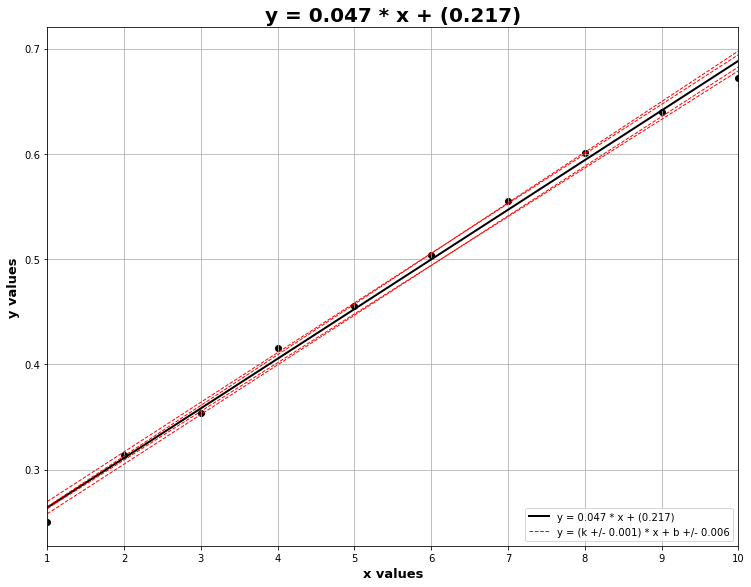

In [35]:
bd = MNK('223_bd.txt')

bd.read_data()
bd.show_schedule()

In [36]:
print(count_lamb(0.07, 0.047))

671


**Синий цвет, светлые полосы**

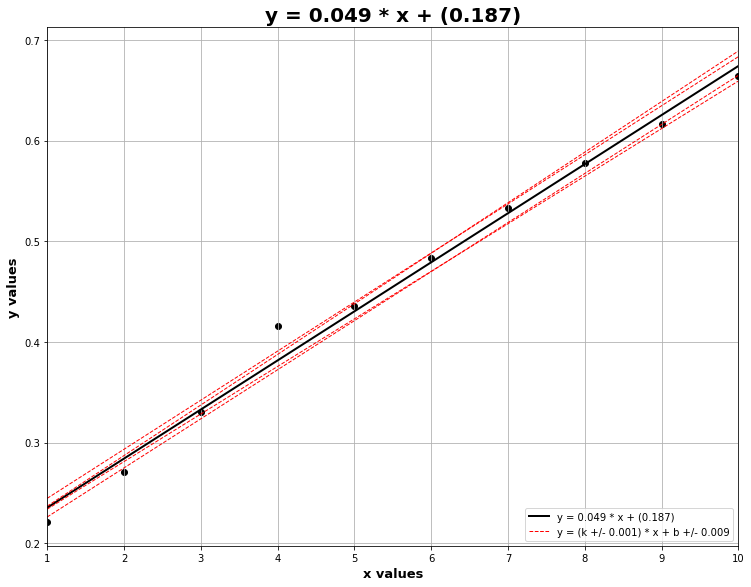

In [37]:
bd = MNK('223_bl.txt')

bd.read_data()
bd.show_schedule()

In [38]:
print(count_lamb(0.07, 0.049))

700


**Красный цвет, тёмные полосы**

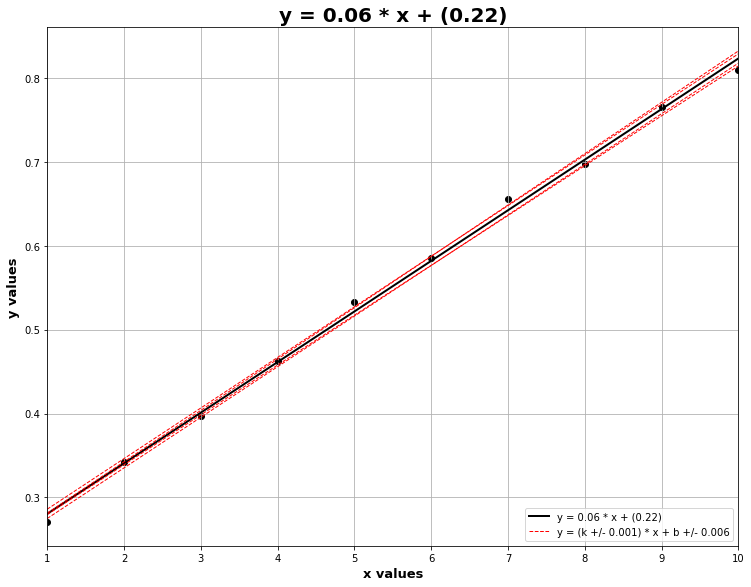

In [39]:
bd = MNK('223_rd.txt')

bd.read_data()
bd.show_schedule()

In [40]:
print(count_lamb(0.07, 0.06))

857


**Красный цвет, светлые полосы**

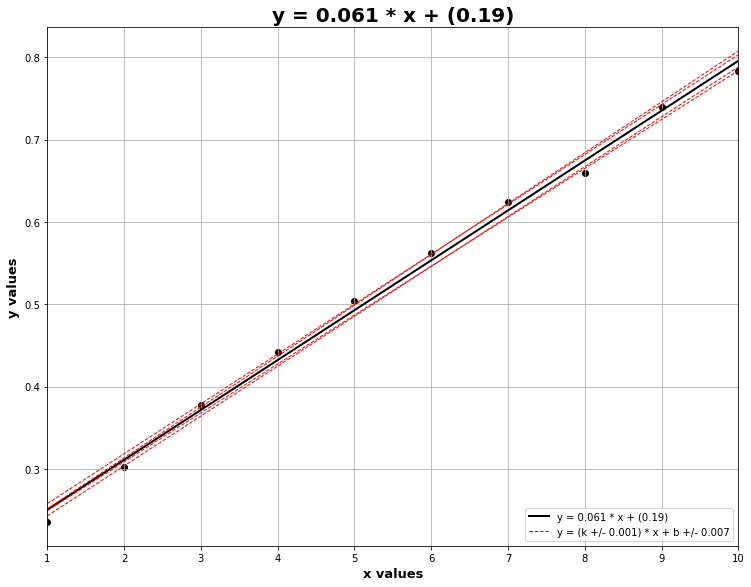

In [41]:
bd = MNK('223_rl.txt')

bd.read_data()
bd.show_schedule()

In [42]:
print(count_lamb(0.07, 0.061))

871


**Жёлтый цвет, тёмные полосы**

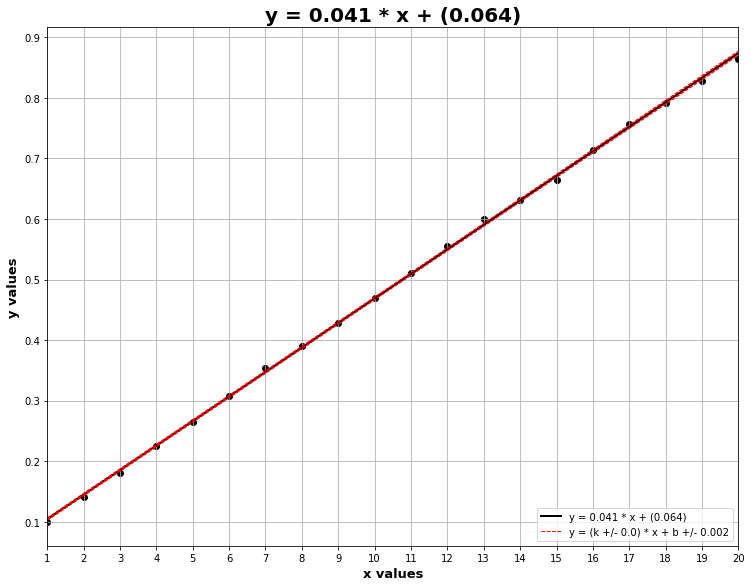

In [43]:
bd = MNK('223_yd.txt')

bd.read_data()
bd.show_schedule()

In [44]:
print(count_r(580 * 10 **(-9), 0.041))

0.07


**Жёлтый цвет, светлые полосы**

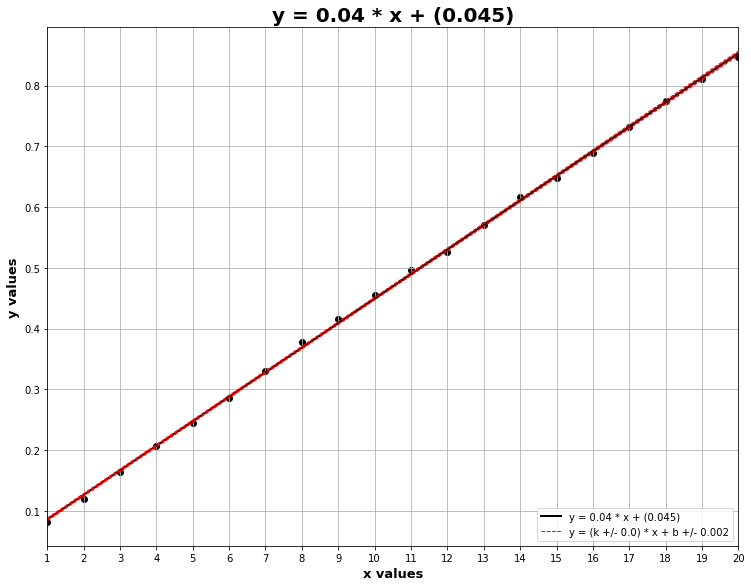

In [45]:
bd = MNK('223_yl.txt')

bd.read_data()
bd.show_schedule()

In [46]:
print(count_r(580 * 10 **(-9), 0.04))

0.07


**Зелёный цвет, тёмные полосы**

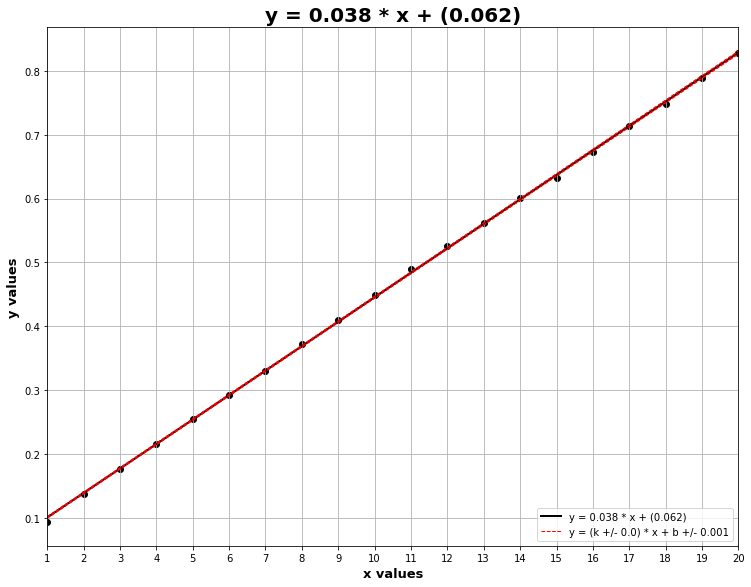

In [47]:
bd = MNK('223_gd.txt')

bd.read_data()
bd.show_schedule()

In [48]:
print(count_r(546 * 10 **(-9), 0.038))

0.07


**Зелёный цвет, светлые полосы**

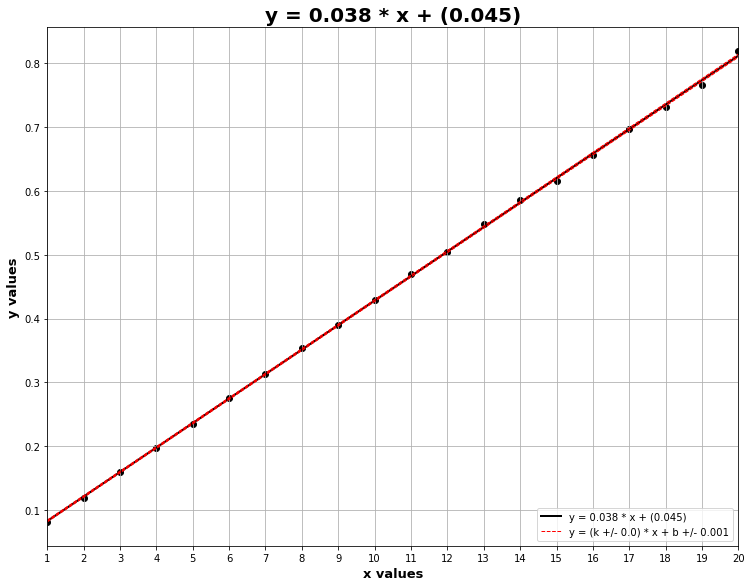

In [49]:
bd = MNK('223_gl.txt')

bd.read_data()
bd.show_schedule()

In [30]:
print(count_r(546 * 10 **(-9), 0.038))

0.07
